# Bicycle Counter Prediction

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import warnings

## 1. Introduction

Ghent introduced bicycle counting points throughout the city as part of their mobility research. The policy promotes bicycles as an eco-friendly mode of transportation for sustainable urban mobility. Based on nearly three years of historical data, gathered at the Coupure counting point, I will predict the counts for the month of July 2023.

The project is structured into several sections, starting with data gathering and preprocessing. Next I'll perform exploratory data anslysis to undestand the data and subsequently feature engineering, creating new variables that might improve the model's performance. Finally I will perform hyperparameter tuning, the model and an evaluation.

## 2. Data gathering

In [ ]:
# download extended bycicle counter datasets (!wget if not on UNIX)
!curl 'https://data.stad.gent/api/explore/v2.1/catalog/datasets/fietstelpaal-coupure-links-2023-gent/exports/csv?lang=en&timezone=Europe%2FBrussels&use_labels=true&delimiter=%3B' -o 'data/fiets_2023.csv'
!curl 'https://data.stad.gent/api/explore/v2.1/catalog/datasets/fietstelpaal-coupure-links-2022-gent/exports/csv?lang=en&timezone=Europe%2FBrussels&use_labels=true&delimiter=%3B' -o 'data/fiets_2022.csv'
!curl 'https://data.stad.gent/api/explore/v2.1/catalog/datasets/fietstelpaal-coupure-links-2021-gent/exports/csv?lang=en&timezone=Europe%2FBrussels&use_labels=true&delimiter=%3B' -o 'data/fiets_2021.csv'

# Download weather data
!curl 'https://archive-api.open-meteo.com/v1/archive?latitude=51.100006&longitude=3.699997&start_date=2021-03-01&end_date=2023-07-31&hourly=temperature_2m,precipitation,rain,snowfall,snow_depth,cloudcover,windspeed_10m,windgusts_10m&format=csv' -o 'data/weather_data_full.csv'

## 3. Preprocessing

In [2]:
# Load in data
fiets_2023 = pd.read_csv('./data/fiets_2023.csv',delimiter=';')
fiets_2022 = pd.read_csv('./data/fiets_2022.csv',delimiter=';')
fiets_2021 = pd.read_csv('./data/fiets_2021.csv',delimiter=';')

weather_data = pd.read_csv('./data/weather_data_full.csv',skiprows=3)
test_data = pd.read_csv('./data/test_data.csv')

# concatenate the training data
train_data = pd.concat([fiets_2021, fiets_2022, fiets_2023], ignore_index=True)

In [3]:
# Convert time columns to pandas datetime format
## test data
test_data['datetime'] = pd.to_datetime(test_data['Date_hour'])

## train data
train_data['datetime'] = pd.to_datetime(train_data['Datum']+ ' ' + train_data['Uur5Minuten'])

## weather data
weather_data['datetime'] = pd.to_datetime(weather_data['time'])

In [4]:
# drop irrelevant time columns
train_data = train_data[['datetime','Totaal']]
weather_data = weather_data.drop('time',axis =1)
test_data = test_data.drop('Date_hour',axis=1)

# Remove datapoints later than 30th of june 2023
train_data = train_data[train_data['datetime'] <= '2023-06-30 23:00']

# Group by hour
train_data = train_data.groupby(train_data['datetime'].dt.strftime('%Y-%m-%d %H:00'))['Totaal'].sum()

# reset index
train_data = train_data.reset_index()

# reset "datetime" column to pandas datetime format as this changes to "object" type during execution of the "groupby" function.
train_data['datetime'] = pd.to_datetime(train_data['datetime'])

In [5]:
# Merge weather data with training data and test data, based on timepoints
train_data = pd.merge(train_data, weather_data, on='datetime', how='inner')
test_data = pd.merge(test_data, weather_data, on='datetime', how='inner')

# index
test_data.set_index('Id')

,datetime,temperature_2m (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),cloudcover (%),windspeed_10m (km/h),windgusts_10m (km/h)
Id,,,,,,,,,
0,2023-07-01 00:00:00,18.0,0.0,0.0,0.0,0.0,100,18.8,37.1
1,2023-07-01 01:00:00,17.7,0.0,0.0,0.0,0.0,100,20.4,39.6
2,2023-07-01 02:00:00,17.4,0.0,0.0,0.0,0.0,100,21.9,41.0
3,2023-07-01 03:00:00,17.2,0.0,0.0,0.0,0.0,100,21.7,41.8
4,2023-07-01 04:00:00,17.2,0.0,0.0,0.0,0.0,100,20.9,41.8
...,...,...,...,...,...,...,...,...,...
739,2023-07-31 19:00:00,17.6,0.4,0.4,0.0,0.0,100,17.5,30.2
740,2023-07-31 20:00:00,17.3,0.1,0.1,0.0,0.0,98,17.0,31.7
741,2023-07-31 21:00:00,17.0,0.1,0.1,0.0,0.0,82,17.1,32.8


## 4. Data exploration

In this section I will analyse the data by looking at missing data, correlations, linearity,...
Performing a Principle Component Analysis to detect valueable features seems unnecessary as we are not dealing with a large number of variables.

### 4.1 Correlation analysis

Totaal                  1.000000
temperature_2m (°C)     0.222536
windgusts_10m (km/h)    0.075790
snow_depth (m)          0.015638
windspeed_10m (km/h)    0.012239
cloudcover (%)          0.011943
precipitation (mm)      0.008858
rain (mm)               0.008830
snowfall (cm)           0.000880
Name: Totaal, dtype: float64


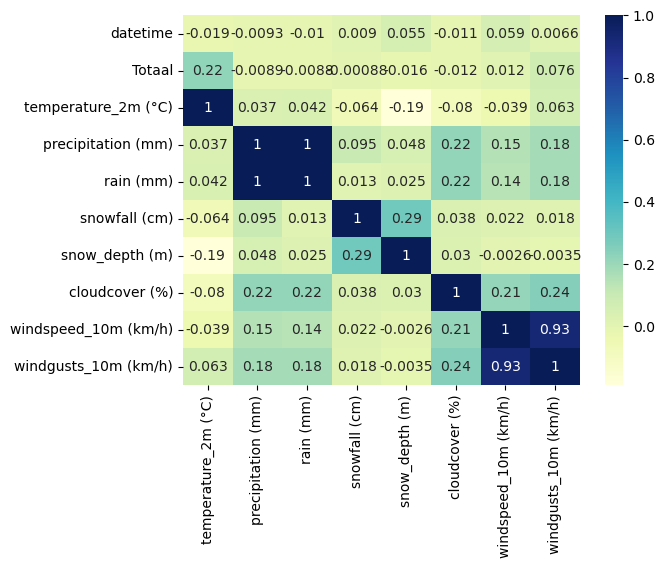

In [6]:
correlation = train_data.corr()['Totaal'].drop('datetime')
print(correlation.abs().sort_values(ascending=False))


# Correlation matrix
correlation_matrix = train_data.corr()
sns.heatmap(train_data.corr().drop(columns=['Totaal','datetime']), annot=True, cmap='YlGnBu')
plt.show()

**Observations**:
- Some variables such as temperature and windgusts show a decent correlation with the total number of cyclists. Those will be retained.
- Some variables such as rain and snowfall show low correlation with the total number of cyclists. Those will be removed.
- Strong multicollinearity between precipitation-rain, windspeed-windgusts and snowfall-snowdepth. One of each pair has to be removed to avoid multicollinearity in the model.

In [7]:
# changes prompted by exploration
train_data = train_data.drop(columns=['snow_depth (m)','windspeed_10m (km/h)','cloudcover (%)','precipitation (mm)','rain (mm)','snowfall (cm)'])
test_data = test_data.drop(columns=['snow_depth (m)','windspeed_10m (km/h)','cloudcover (%)','precipitation (mm)','rain (mm)','snowfall (cm)'])

### 4.2 Basic information

In [8]:
# Check for missing data
missing_data = train_data.isnull()
print(missing_data.sum())

datetime                0
Totaal                  0
temperature_2m (°C)     0
windgusts_10m (km/h)    0
dtype: int64


There is no missing data.

In [9]:
# Check basic statistics and data structure
print(train_data.describe())

                  datetime        Totaal  temperature_2m (°C)  \
count                20448  20448.000000         20448.000000   
mean   2022-04-30 23:30:00    289.190288            11.719219   
min    2021-03-01 00:00:00      0.000000            -4.900000   
25%    2021-09-29 23:45:00     67.750000             7.000000   
50%    2022-04-30 23:30:00    227.000000            11.400000   
75%    2022-11-29 23:15:00    397.000000            16.200000   
max    2023-06-30 23:00:00   1953.000000            36.600000   
std                    NaN    280.330023             6.394352   

       windgusts_10m (km/h)  
count          20448.000000  
mean              26.593153  
min                0.400000  
25%               16.600000  
50%               24.500000  
75%               33.800000  
max              110.500000  
std               13.315181  


### 4.3 General Structure Analysis

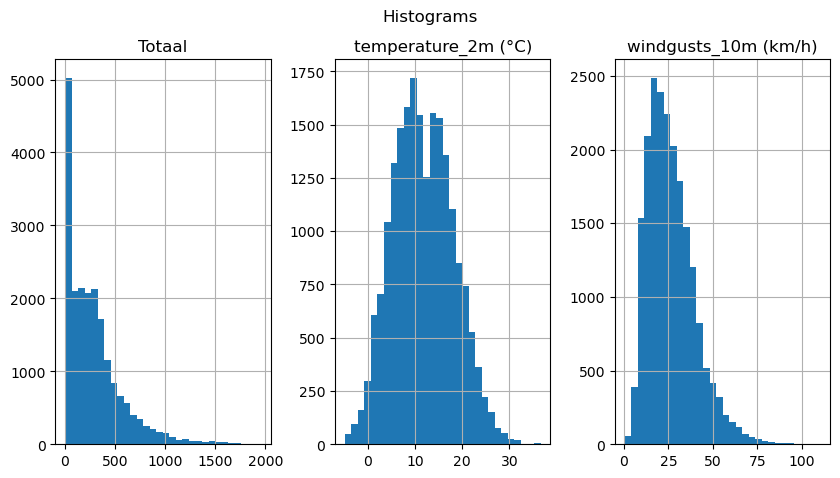

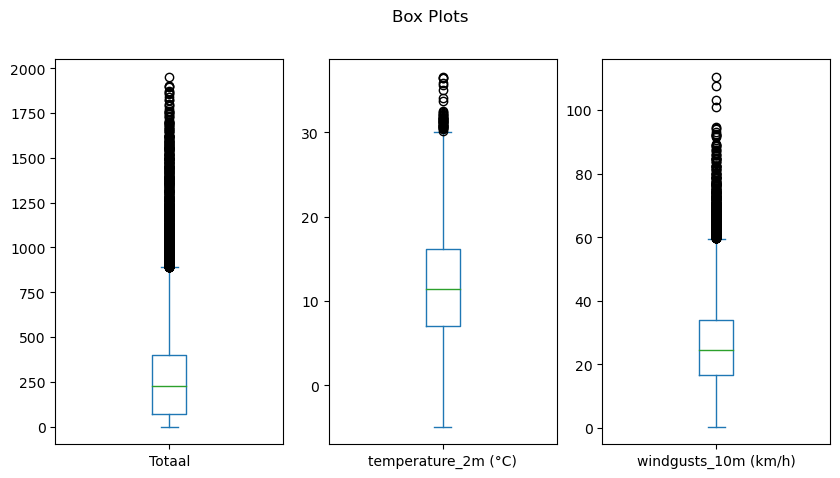

In [10]:
features = train_data.select_dtypes(include='number')

# Histograms
features.hist(figsize=(10, 5),bins=30,layout=(1,3))
plt.suptitle("Histograms")
plt.show()

# Boxplots
features.plot(kind='box', subplots=True, figsize=(10, 5),layout=(1,3))
plt.suptitle("Box Plots")
plt.show()

**Observations**:
- The temperature data seems to display a normal distribution.
- The windgusts data shows a moderate positive skew.
- The total number of cyclists shows an exponential distribution.
- The boxplots seem to confirm the distributions by portraying a large number of outliers to the right tail (positive skew), mainly in windgusts and totals.

### 4.4 Linearity analysis

/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


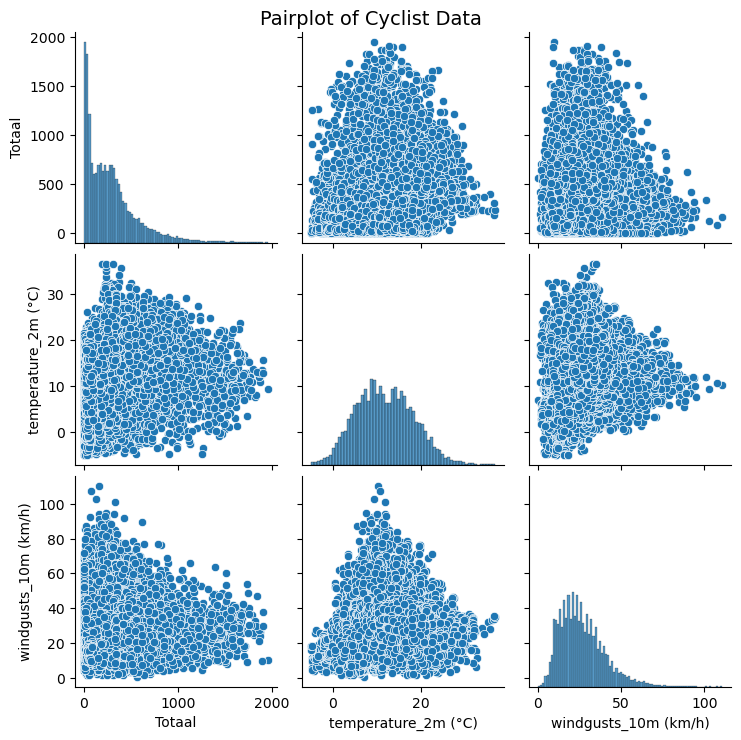

In [11]:
# Filter out FutureWarnings due to excessive warnings about a deprecated function...
warnings.filterwarnings("ignore", category=FutureWarning)

# Pairplot
fig = sns.pairplot(train_data)
plt.subplots_adjust(top=0.95)
fig.fig.suptitle("Pairplot of Cyclist Data", fontsize=14)
plt.show()

# Reset the warning filter
warnings.resetwarnings()

**Observations**:
- A relationship with intuitive explanation can be observed between the features and number cyclists. Large windgusts and extreme temperatures on both tails prompt less cyclists.
- Despite this relationship, linearity cannot be positively confirmed. A linear regression model most likely won't be able to capture the variability.

### 4.5 Time Series Analysis

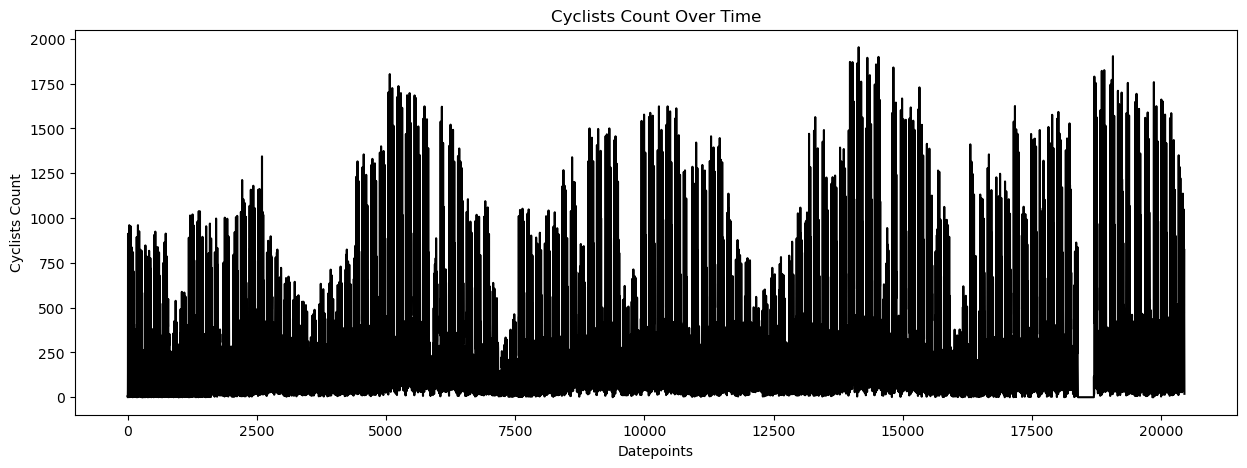

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(train_data.index, train_data['Totaal'], color='black')
plt.xlabel('Datepoints')
plt.ylabel('Cyclists Count')
plt.title('Cyclists Count Over Time')
plt.show()

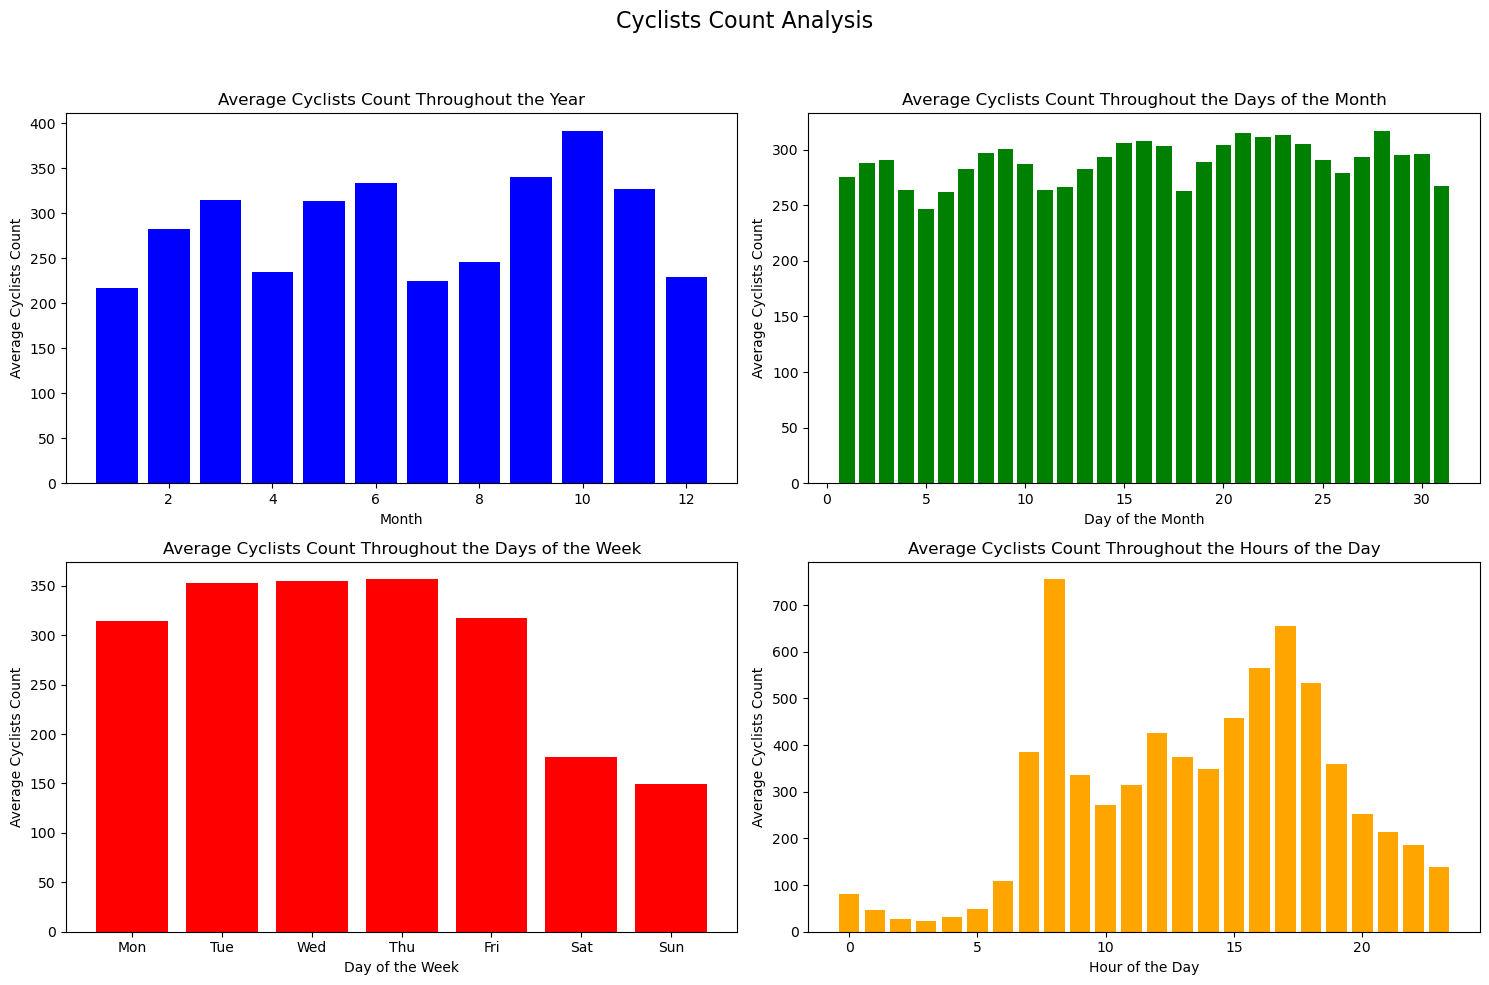

In [13]:
# Set datetime as index
train_data.set_index('datetime', inplace=True)

# Grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Cyclists Count Analysis', fontsize=16)

# Average Cyclists Count Throughout the Month
monthly_avg = train_data['Totaal'].groupby(train_data.index.month).mean()
axes[0, 0].bar(monthly_avg.index, monthly_avg, color='blue')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Average Cyclists Count')
axes[0, 0].set_title('Average Cyclists Count Throughout the Year')

# Average Cyclists Count Throughout the Days of the Month
daily_avg = train_data['Totaal'].groupby(train_data.index.day).mean()
axes[0, 1].bar(daily_avg.index, daily_avg, color='green')
axes[0, 1].set_xlabel('Day of the Month')
axes[0, 1].set_ylabel('Average Cyclists Count')
axes[0, 1].set_title('Average Cyclists Count Throughout the Days of the Month')

# Average Cyclists Count Throughout the Days of the Week
days_avg = train_data['Totaal'].groupby(train_data.index.dayofweek).mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 0].bar(days, days_avg, color='red')
axes[1, 0].set_xlabel('Day of the Week')
axes[1, 0].set_ylabel('Average Cyclists Count')
axes[1, 0].set_title('Average Cyclists Count Throughout the Days of the Week')

# Average Cyclists Count Throughout the Hours of the Day (New Plot)
hourly_avg = train_data['Totaal'].groupby(train_data.index.hour).mean()
axes[1, 1].bar(hourly_avg.index, hourly_avg, color='orange')
axes[1, 1].set_xlabel('Hour of the Day')
axes[1, 1].set_ylabel('Average Cyclists Count')
axes[1, 1].set_title('Average Cyclists Count Throughout the Hours of the Day')


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# reset index
train_data = train_data.reset_index()

**Observations**:
- Moderate seasonality can be observed throughout the months of the year with a peak towards the end of the year in October. Average cyclists vary up to 50% per between months. Adding this variable will most likely improve the model.
- Throughout the month, barely any seasonality can be observed. Adding a variable for day-of-the-month would seem insignificant.
- A strong, clear trend can be observed throughout the week. The weekend shows strongly reduced numbers. Adding this variable will be a strong asset.
- The strongest trend can be observed throughout the day, the hours indicate different average counts.
- Adding these variables will capture a decent amount of patterns. To strenghten the model even more, festivals, holidays and special events could be added at the risk of overfitting.

## 5. Feature engineering

### 5.1 Gentse feesten binary

In [14]:
# gentse feesten 2022
gentse_feesten_start_2022 = pd.to_datetime('2022-07-15')
gentse_feesten_end_2022 = pd.to_datetime('2022-07-24')

train_data['is_gentse_feesten_active'] = (
    (train_data['datetime'] >= gentse_feesten_start_2022) &
    (train_data['datetime'] <= gentse_feesten_end_2022)
).astype(int)


# Gentse feesten 2023
gentse_feesten_start_2023 = pd.to_datetime('2023-07-14')
gentse_feesten_end_2023 = pd.to_datetime('2023-07-23')

test_data['is_gentse_feesten_active'] = (
    (test_data['datetime'] >= gentse_feesten_start_2023) &
    (test_data['datetime'] <= gentse_feesten_end_2023)
).astype(int)

### 5.2 Time related features

In [15]:
## 1. Time related features: train_data

# Hour of the day
train_data['hour'] = train_data['datetime'].dt.hour
train_data = pd.get_dummies(train_data, columns=['hour'], prefix='hour', prefix_sep='_')

# Day of the week
days_dummies = pd.get_dummies(train_data['datetime'].dt.dayofweek, prefix='day', prefix_sep='_')
train_data = pd.concat([train_data, days_dummies], axis=1)

# Months - dummy variables
months_dummies = pd.get_dummies(train_data['datetime'].dt.month, prefix='month')
train_data = pd.concat([train_data, months_dummies], axis=1)


In [16]:
## 2. Time related features: test_data

# Extract hours into dummy variables
test_data['hour'] = test_data['datetime'].dt.hour
test_data = pd.get_dummies(test_data, columns=['hour'], prefix='hour', prefix_sep='_')

# Day of the week
days_dummies = pd.get_dummies(test_data['datetime'].dt.dayofweek, prefix='day', prefix_sep='_')
test_data = pd.concat([test_data, days_dummies], axis=1)

# months:
months_dummies = pd.get_dummies(test_data['datetime'].dt.month, prefix='month')
test_data = pd.concat([test_data, months_dummies], axis=1)


missing_months = [column for column in set(train_data.columns) if column.startswith("month") and column not in set(test_data.columns)]
for column in missing_months:
    test_data[column] = False

In [17]:
# drop datetime columns
train_data = train_data.drop('datetime', axis=1)
test_data = test_data.drop('datetime', axis=1)

In [18]:
# Current model variables
print(train_data.columns)

Index(['Totaal', 'temperature_2m (°C)', 'windgusts_10m (km/h)',
       'is_gentse_feesten_active', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5',
       'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'],
      dtype='object')


**Notes**:
- Adding binary variables for is-weekend, is-summer-vacation and is-working-hours is redundant as the variance is already explained by the days of the week, months of the year and hours of the day. Adding them would result in multicollinearity with months 7 and 8, days 6 and 7 and hours 9 to 5.
- I opted for using dummy variables to capture the variance of the days, months and hours. This model shows a better result than using continuous variables.
- I also attempted capturing cyclic behavior of the hour of the day and day of the week by encoding as sin/cos values. This also did not improve the model's performance.
- Lastly i also added interaction terms to the model, this did not improve the model's performance either.

## 6. Correlation analysis - revisited

In [19]:
correlation = train_data.corr()['Totaal']
print(correlation.abs().sort_values(ascending=False))

Totaal                      1.000000
hour_8                      0.346649
hour_17                     0.271887
temperature_2m (°C)         0.222536
hour_16                     0.206183
day_6                       0.202826
hour_3                      0.198671
hour_2                      0.194621
hour_4                      0.192372
hour_18                     0.181235
hour_1                      0.179978
hour_5                      0.178185
day_5                       0.163573
hour_0                      0.154505
hour_6                      0.134173
hour_15                     0.125331
hour_23                     0.112456
hour_12                     0.102070
month_10                    0.101949
day_3                       0.098009
day_2                       0.096388
day_1                       0.093398
hour_22                     0.076075
windgusts_10m (km/h)        0.075790
month_1                     0.072220
hour_7                      0.071614
month_4                     0.067241
m

These new time-related variables show decent correlation with the number of cyclists and will be retained in the model.

## 7. Model

In [20]:
# Store data in numpy arrays
y = train_data.Totaal.values
X = train_data.drop('Totaal', axis=1).values

In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7) # Use 70% of data for training

### 7.1 Hyperparameter tuning

In [22]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10],
    'gamma': [0, 0.1, 0.2]
}

model = XGBRegressor(
    objective='reg:squarederror'
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

**Notes**:

I have chosen to focus on the 4 most important hyperparameters for tuning the algorithm. Others like 'min_child_weight', 'subsample' and 'gamma' can also improve the model, but only marginally when compared to the first 3.

- **n_estimators**: The number of trees, this will increase complexity.
- **learning_rate**: Determines how fast/slow the algorithm moves towards the optimal weights. If this is large, the model learns faster but could skip the optimal solution. If it's rather small, it may take significantly longer to train as it will need too many iterations to converge to the best values.
- **max_depth**: Controls how deep the tree goes. Increasing this parameter increases the number of splits, capturing more information at the risk of overfitting.

**Cross validation folds** are set to 5 due to the size of the dataset. A higher number of folds yield more statistically significant results but require more computational resources.

#### 7.2 Model implementation

In [27]:
# Perform prediction
y_hat_train = best_model.predict(X_train) # predict training data
y_hat_test = best_model.predict(X_test) # predict test data

# Negative counts don't exist so these are converted to 0
y_hat_train[y_hat_train < 0] = 0
y_hat_test[y_hat_test < 0] = 0

#### 7.3 Evaluation

In [28]:
MSE_train = mean_squared_error(y_train, y_hat_train) # Compute training set MSE
MSE_test = mean_squared_error(y_test, y_hat_test) # Test set MSE
R_train = best_model.score(X_train, y_train) # Training set R²
R_test = best_model.score(X_test, y_test) # Test set R²

print('Training set MSE: {}'.format(MSE_train))
print('Test set MSE: {}'.format(MSE_test))
print('Train set R²: {}'.format(R_train))
print('Test set R²: {}'.format(R_test))

Training set MSE: 8055.794375037611
Test set MSE: 13344.50047605803
Train set R²: 0.8969513185172396
Test set R²: 0.8289097679690172


/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


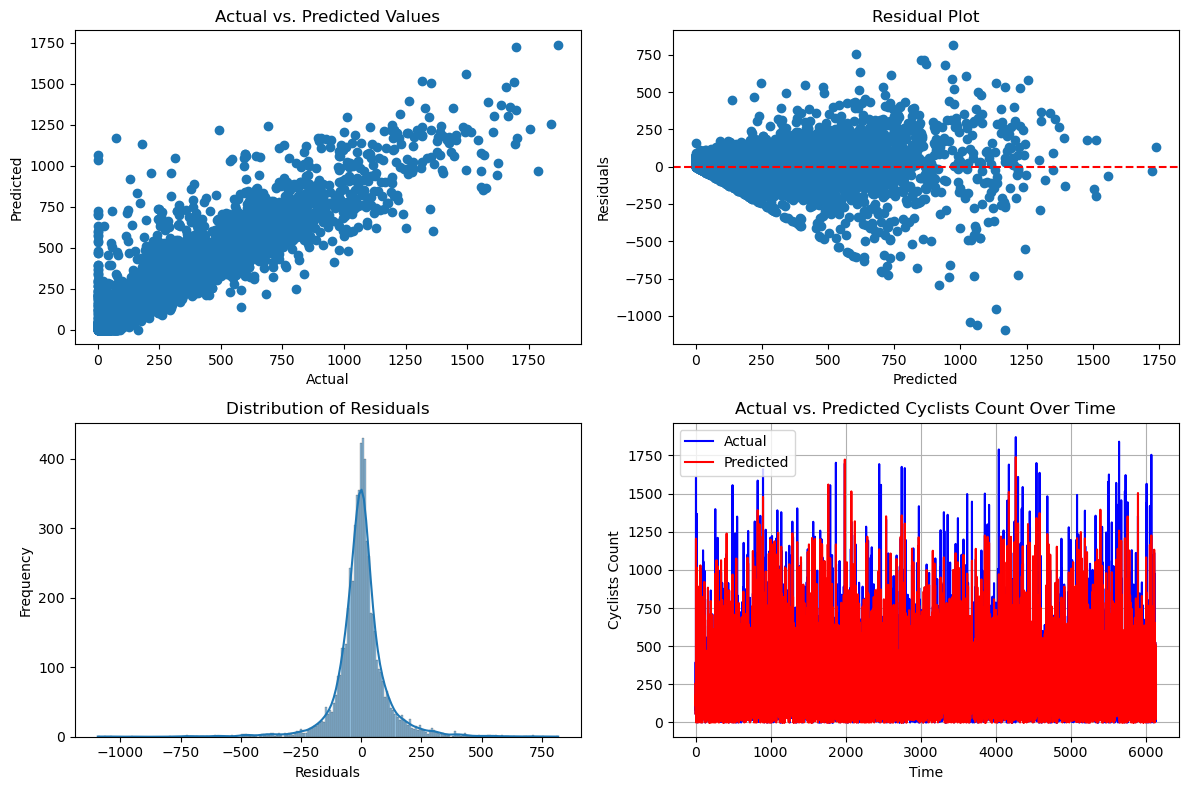

In [29]:
# Create subplots with a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Scatterplot of Actual vs. Predicted Values
axes[0, 0].scatter(y_test, y_hat_test)
axes[0, 0].set_xlabel('Actual')
axes[0, 0].set_ylabel('Predicted')
axes[0, 0].set_title('Actual vs. Predicted Values')

# 2. Residual Plot
residuals = y_test - y_hat_test
axes[0, 1].scatter(y_hat_test, residuals)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')

# 3. Distribution of Residuals
sns.histplot(residuals, kde=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')

# 4. Time Series Plot
axes[1, 1].plot(y_test, label='Actual', color='blue')
axes[1, 1].plot(y_hat_test, label='Predicted', color='red')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Cyclists Count')
axes[1, 1].set_title('Actual vs. Predicted Cyclists Count Over Time')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

##### A. Observations
- Predicted vs actual values plot: The points are scattered around the diagonal, which suggests that the model's predictions are relatively close to the actual values. However, there is some variation that is not captured by the model.
- Residual plot: while a lot of points are centered around the horizontal, quite some points deviate from it, which suggests that the model may not capture all the underlying relationships in the data.
- Residual distribution plot and overlay plot: the healthy distribution and overlay plot seem to indicate that the model does a good job at avoiding both under- as overfitting.
- The MSE of the training set and test set respectively are 8055 and 13344.
- The R² of the training set and test set respectively are 0.90 and 0.83.
- These metrics suggest a good result for this model, capturing between 80 and 90 percent of the variance without excessive under- or overfitting.

##### B. Performances of other attempted models

**Linear regression evaluation**:
- Training set MSE: 27249.11556827259
- Test set MSE: 26764.797759618872
- Train set R²: 0.6569709962614637
- Test set R²: 0.6505101800469617

**Random forest regression**:
- Training set MSE: 2054.7499428536858
- Test set MSE: 15165.465627895834
- Train set R²: 0.9741335154873947
- Test set R²: 0.801972131476596

XGBoost outperformed linear regression and slightly surpassed random forest regression mainly due to its ability to handle non-linear relationships, apply regularization effectively, undergo optimized hyperparameter tuning and incorporate cross-validation for rigorous evaluation.

## 8. Kaggle

In [31]:
# This code is to perform the training on all of the data and generate a submission file for kaggle.

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10],
    'gamma': [0, 0.1, 0.2]
}

model = XGBRegressor(
    objective='reg:squarederror'
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X)

y_pred[y_pred < 0] = 0

# format predictions with Ids into dataframe and save to csv.
submission_file = pd.DataFrame([test_data["Id"], y_pred]).T
submission_file.columns = ["Id", "Predicted"]

submission_file.to_csv("submission.csv", index = False)

## 9. Conclusion

An optimal result was produced by using a tuned XGBoost model, the open-source regularizing gradient boosting framework. The model was trained on a dataset containing weather- and time-related features including the temperature, wingusts, hour, month, day, gentse feesten,... Testing on split data resulted in a good result with a R² of more than 0.8. The difference in R² between the proprietary testset and kaggle testset can be mainly attributed to unforeseen external variables that affect the month of July. Including the Gentse feesten and vacation period as features, did not fully reduce this difference. While testing on the month of July is a great challenge, the model cannot be fairly evaluated this way. A more fair evaluation would be by testing on datapoints, randomly selected throughout the year.

In a situation of unlimited funds, time and motivation, the next steps would be to continue adding features including lagging features to capture a delay, bank holidays, traffic-related features, events, campus Coupure lectures and so on. A wider range of hyperparameters could be explored to identify the optimal configuration for the model. Advanced time-series models could be used which might capture complex temporal patterns better. Other, more complex models could be explored such as neural networks. A system for anomaly detection could be developed to separate random outliers from trends. The model could be deployed and continued in real time, making it possible to generate real-time predictions and monitor its performance.